In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from cdo import Cdo
import os
import glob
from src.Experiments_infos import Data
import xarray as xr
import numpy as np
import  matplotlib.pyplot as plt
from src.Enumerations import Season
from src.plot_funcs import plot_contourf_rotated_grid


/work/aa0238/a271093/Conda/MOAAP_env/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:

exp = Data.ICON_CNRM_EXP
cdo = Cdo()
level=85000

In [3]:
year_start= 1984
year_end= 2014


In [9]:
paths_reg = sorted(glob.glob(exp.FI850p_path_raw+f'FI850p_*-*.ncz'))
paths_reg
" ".join(exp.gph_files_raw_gcm)
exp.FI850p_path_raw

'/work/aa0049/a271109/spice-v2.1/chain/work/polarres_wp3_cmip_CNRM/post/yearly/FI8500p/'

In [10]:
paths_reg = sorted(glob.glob(exp.FI850p_path_raw+f'FI850p_*-*.ncz'))

cdo.selyear(f'{year_start}/{year_end}',
            input = '-divc,9.81 -daymean -mergetime '+' '.join(paths_reg),
            output = f'{exp.scratch_path}gph{level}_reg_dummy.nc' )
             
cdo.remapbil(exp.regional_30km_target_grid,
             input=  f'{exp.scratch_path}gph{level}_reg_dummy.nc',
             output= f'{exp.scratch_path}gph{level}_reg_CNRM_3dx3dy.nc')
             
#os.system(f"rm {exp.scratch_path}gph{level}_dummy.nc")



'/work/aa0238/a271093/scratch/gph85000_reg_CNRM_3dx3dy.nc'

In [11]:

cdo.remapbil(exp.regional_30km_target_grid,
             input= f'-selyear,{year_start}/{year_end} -sellevel,{level} -mergetime  '+" ".join(exp.gph_files_raw_gcm),
             output = f'{exp.scratch_path}gph{level}_gcm_CNRM_3dx3dy.nc' )

'/work/aa0238/a271093/scratch/gph85000_gcm_CNRM_3dx3dy.nc'

In [12]:
gph_reg=xr.load_dataset(f'{exp.scratch_path}gph{level}_reg_CNRM_3dx3dy.nc')
#gph_reg = gph_reg.sel(time=~((gph_reg.time.dt.month == 2) & (gph_reg.time.dt.day == 29)))

gph_gcm=xr.load_dataset(f'{exp.scratch_path}gph{level}_gcm_CNRM_3dx3dy.nc')
gph_gcm = np.squeeze(gph_gcm)

Season.WINTER
Season.SPRING
Season.SUMMER
Season.AUTUMN


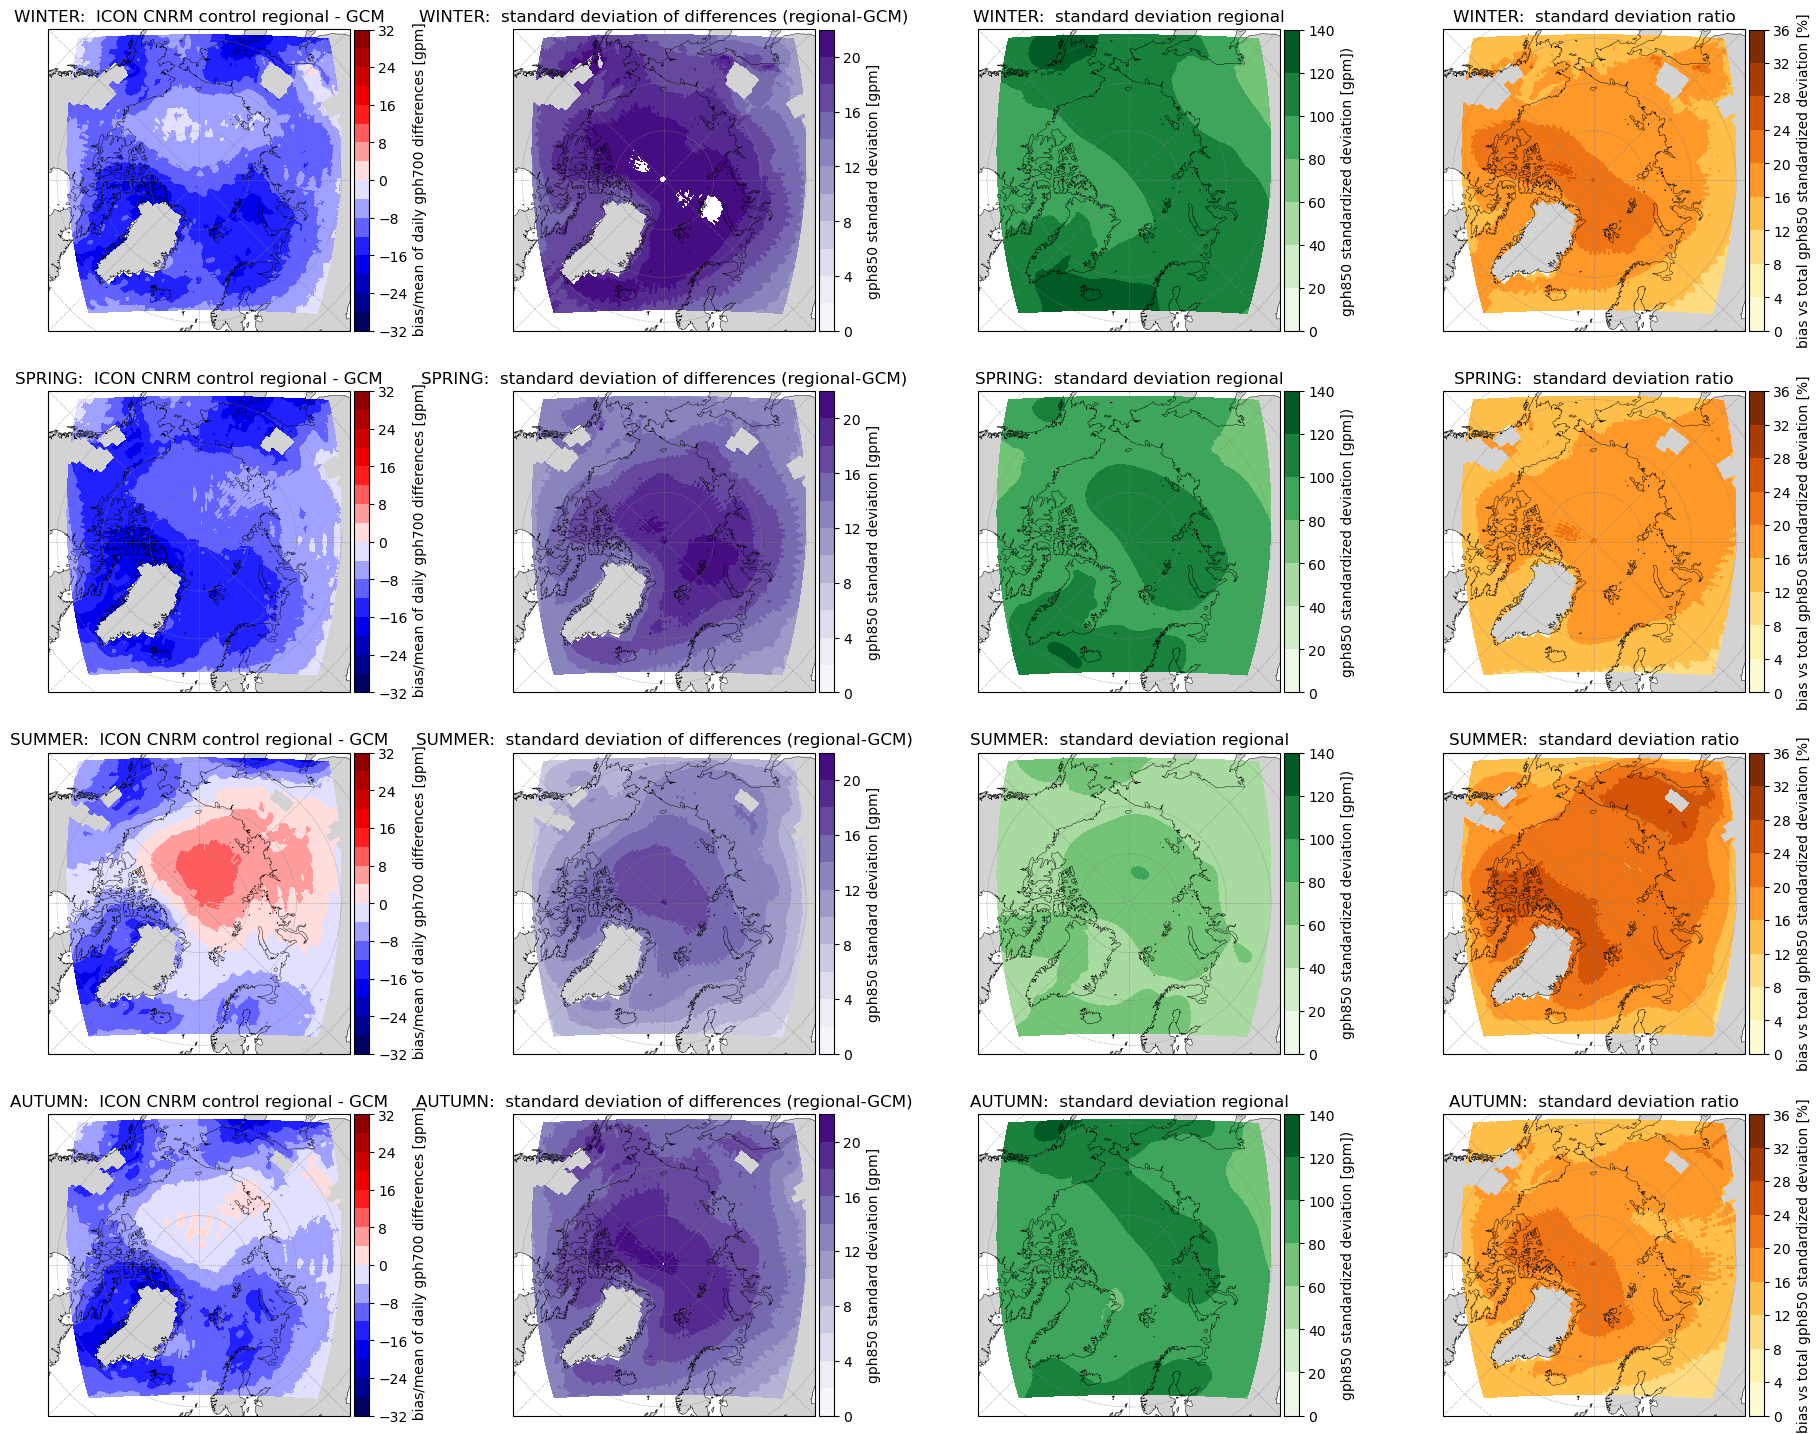

In [17]:
fig = plt.figure(figsize=(23,18))
for  season_, i in zip(Season,[0,4,8,12]):
    print (season_)
    reg_sel = gph_reg.sel(time=gph_reg.time.dt.month.isin(season_.value))
    gcm_sel = gph_gcm.sel(time=gph_gcm.time.dt.month.isin(season_.value))
    
    error = np.mean((reg_sel.FI.values - gcm_sel.zg.values), axis=0)


    plot_contourf_rotated_grid(gph_reg.rlon.values,
                               gph_reg.rlat.values,
                               error, index =i,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  ICON CNRM control regional - GCM',
                              levels =np.arange(-32,33,4),
                              cbar_label= "  bias/mean of daily gph700 differences [gpm] ",
                              cmap="seismic")
    
    
    std_bias = np.std((reg_sel.FI.values- gcm_sel.zg.values),axis=0)
                  
    plot_contourf_rotated_grid(gph_reg.rlon.values,
                               gph_reg.rlat.values,
                               std_bias, index =i+1,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  standard deviation of differences (regional-GCM)',
                              #levels =np.arange(0,25,2),
                              levels =np.arange(0,24,2),

                              cbar_label= "gph850 standard deviation [gpm]",
                              cmap="Purples")

    std_tot  = np.std(reg_sel.FI.values,axis=0)
    
    plot_contourf_rotated_grid(gph_reg.rlon.values,
                               gph_reg.rlat.values,
                               std_tot, index =i+2,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  standard deviation regional',
                              levels =np.arange(0,160,20),
                              cbar_label= "gph850 standardized deviation [gpm])",
                              cmap="Greens")
    
    plot_contourf_rotated_grid(gph_reg.rlon.values,
                               gph_reg.rlat.values,
                               (std_bias/std_tot)*100, index =i+3,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  standard deviation ratio',
                              levels =np.arange(0,40,4),
                              cbar_label= "bias vs total gph850 standardized deviation [%]",
                              cmap="YlOrBr")